In [46]:
#Loading the required packages

#Scikit-Learn & NLTK packages
import nltk
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import string
import textblob as tb
from tqdm import tqdm

#Compuational & Visualisation packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Downloading NLTK stopwords
import nltk
#nltk.download('stopwords')

#Hide Warnings
import warnings
warnings.filterwarnings('ignore')

In [47]:
#Loading the news feed data
news_feed_df = pd.read_csv('../data/news_sentiment_modeller.csv', dtype={'publish_time': object})

In [48]:
print (news_feed_df.info())

In [49]:
#Preprocessing on the dataframe
news_feed_df['publish_hour'] = news_feed_df.publish_time.str[:10]
news_feed_df['publish_date'] = news_feed_df.publish_time.str[:8]
news_feed_df['publish_hour_only'] = news_feed_df.publish_time.str[8:10]
news_feed_df['publish_time_only'] = news_feed_df.publish_time.str[8:12]
news_feed_df['dt_time'] = pd.to_datetime(news_feed_df['publish_time'], format='%Y%m%d%H%M')
news_feed_df['dt_hour'] = pd.to_datetime(news_feed_df['publish_hour'], format='%Y%m%d%H')
news_feed_df['dt_date'] = pd.to_datetime(news_feed_df['publish_date'], format='%Y%m%d')

news_feed_df = news_feed_df.dropna()

In [50]:
news_feed_df[501:508]

,publish_time,feed_code,source_url,headline_text,publish_hour,publish_date,publish_hour_only,publish_time_only,dt_time,dt_hour,dt_date
501,201708240002,w3-wowktv,http://www.tristateupdate.com/story/36202325/p...,Parks Service issues permit for San Francisco ...,2017082400,20170824,00,0002,2017-08-24 00:02:00,2017-08-24,2017-08-24
502,201708240002,w3-wreg,http://wreg.com/2017/08/23/naacp-wants-meeting...,NAACP wants meeting with NFL commissioner abou...,2017082400,20170824,00,0002,2017-08-24 00:02:00,2017-08-24,2017-08-24
503,201708240002,w3-wreg,http://wreg.com/2017/08/23/players-hold-breath...,Players hold breath as $700M Powerball jackpot...,2017082400,20170824,00,0002,2017-08-24 00:02:00,2017-08-24,2017-08-24
504,201708240002,w3-www2-hkej,http://www2.hkej.com/instantnews/international...,道指收市跌87點 - 信報財經新聞,2017082400,20170824,00,0002,2017-08-24 00:02:00,2017-08-24,2017-08-24
505,201708240002,w3-www3-asahi,http://www.asahi.com/articles/ASK8R639MK8RULFA...,東芝メモリ売却、ＷＤと優先交渉 日米韓連合から変更,2017082400,20170824,00,0002,2017-08-24 00:02:00,2017-08-24,2017-08-24
506,201708240002,w3-wxow,http://www.wxow.com/story/36202325/parks-servi...,Parks Service issues permit for San Francisco ...,2017082400,20170824,00,0002,2017-08-24 00:02:00,2017-08-24,2017-08-24
507,201708240002,w3-yourerie,http://www.yourerie.com/news/politics/us-scien...,US science envoy spells out 'impeach' in resig...,2017082400,20170824,00,0002,2017-08-24 00:02:00,2017-08-24,2017-08-24


# Top 10 feeds from the dataset

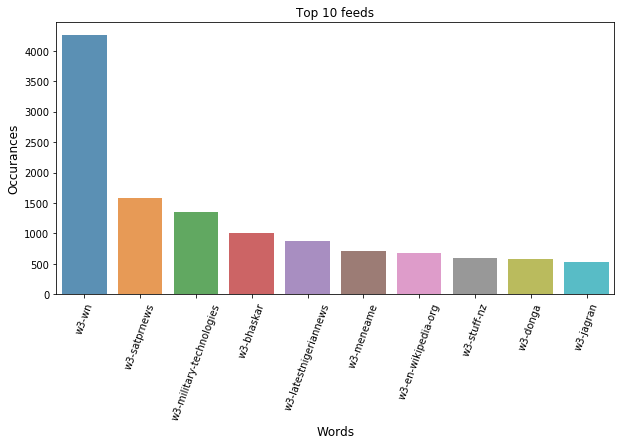

In [51]:
top_10_feeds = news_feed_df['feed_code'].value_counts()
top_10_feeds = top_10_feeds[:10,]
plt.figure(figsize=(10,5))
sns.barplot(top_10_feeds.index , top_10_feeds.values, alpha = 0.8)
plt.title("Top 10 feeds")
plt.ylabel('Occurances', fontsize = 12)
plt.xlabel('Words', fontsize = 12)
plt.xticks(rotation=70)
plt.show()

In [52]:
engStopWords = set(nltk.corpus.stopwords.words('english'))
nonEngStopWords = set(nltk.corpus.stopwords.words()) - engStopWords
stopWordsDict = {lang: set(nltk.corpus.stopwords.words(lang)) for lang in nltk.corpus.stopwords.fileids()}

In [53]:
def get_language(text):
    if type(text) is str:
        text = text.lower()
    words = set(nltk.wordpunct_tokenize(text))
    return max(((lang, len(words & stopwords)) for lang, stopwords in stopWordsDict.items()), key = lambda x: x[1])[0]


In [54]:
news_feed_df['language'] = news_feed_df['headline_text'].apply(get_language)

## Top 10 Languages in the Dataset

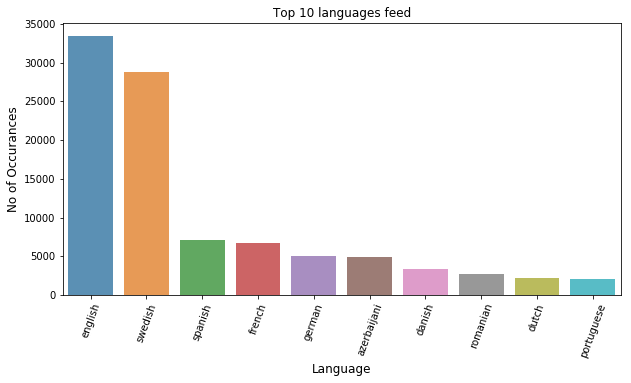

In [55]:
language_count = news_feed_df['language'].value_counts()
language_count = language_count[:10]
plt.figure(figsize = (10,5))
sns.barplot(language_count.index, language_count.values, alpha = 0.8)
plt.title("Top 10 languages feed")
plt.ylabel('No of Occurances', fontsize = 12)
plt.xlabel('Language', fontsize = 12)
plt.xticks(rotation=70)
plt.show()

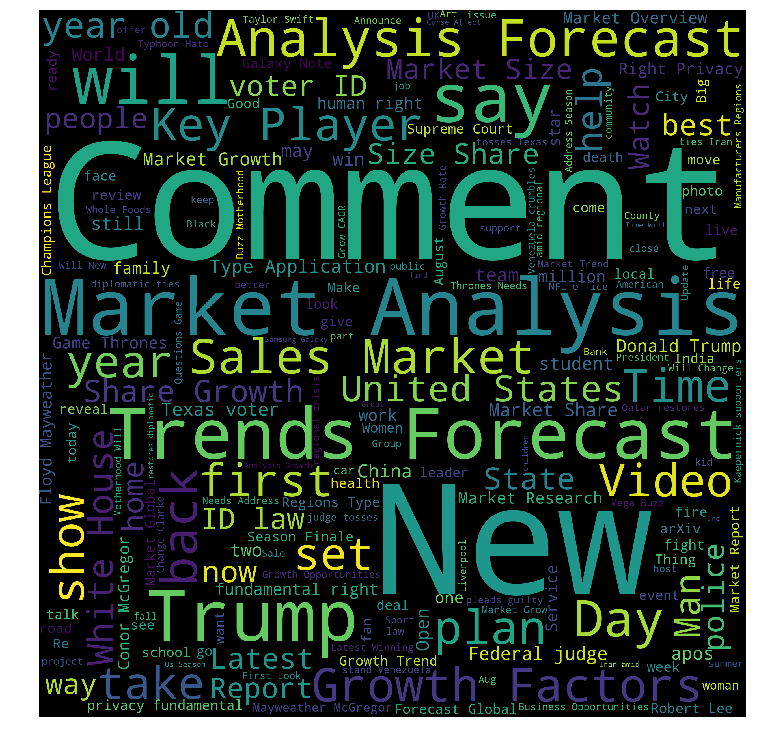

In [56]:
news_feed_english_df = news_feed_df[news_feed_df['language'] == 'english']
news_feed_english = news_feed_english_df['headline_text']

def showWordCloud(data):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()])
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'black', width = 2500, height = 2500 )\
    .generate(cleaned_word)
    plt.figure(1,figsize = (13,13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

showWordCloud(news_feed_english)

## Topic Modelling and Sentiment Analysis

In [57]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx , topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words -1:-1]]))

In [58]:
no_features = 1000
tfidf_vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2,max_features=no_features, stop_words = 'english')
tfidf = tfidf_vectorizer.fit_transform(news_feed_english)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

tf_vectorizer = CountVectorizer(max_df = 0.95, min_df = 2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(news_feed_english)
tf_feature_names = tf_vectorizer.get_feature_names()

In [59]:
no_topic = 6
nmf = NMF(n_components=no_topic, random_state = 1, alpha =.1, l1_ratio=.5, init = 'nndsvd').fit(tfidf)
lda = LatentDirichletAllocation(n_topics=no_topic, max_iter = 5, 
          learning_method = 'online', learning_offset=50., random_state=0).fit(tf)


In [60]:
no_top_words = 15
display_topics(nmf ,tfidf_feature_names, no_top_words)

In [61]:
display_topics(lda , tf_feature_names , no_top_words)

In [62]:
import sys  
reload(sys)  
sys.setdefaultencoding('utf8')

In [63]:
def sent(x):
    t = tb.TextBlob(x)
    return t.sentiment.polarity, t.sentiment.subjectivity

tqdm.pandas(leave = False, mininterval = 25)
vals = news_feed_english_df.headline_text.progress_apply(sent)
news_feed_english_df['polarity'] = vals.str[0]
news_feed_english_df['sub'] = vals.str[1]

In [64]:
type(news_feed_english_df)

pandas.core.frame.DataFrame

In [65]:
def plot_data(df , col):
    mean_pol = list(dict(df.groupby(col)['polarity'].mean()).items())
    mean_pol.sort(key=lambda x: x[0])

    plt.subplots(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.plot([i[0] for i in mean_pol], [i[1] for i in mean_pol])
    plt.xticks(rotation=70)
    plt.title('Mean polarity over time')

    plt.subplot(2, 2, 2)
    mean_pol = list(dict(df.groupby(col)['sub'].mean()).items())
    mean_pol.sort(key=lambda x: x[0])
    plt.plot([i[0] for i in mean_pol], [i[1] for i in mean_pol])
    plt.xticks(rotation=70)
    plt.title('Mean subjectivity over time')

    plt.subplot(2, 2, 3)
    mean_pol = list(dict(df.groupby(col)['polarity'].std()).items())
    mean_pol.sort(key=lambda x: x[0])
    plt.plot([i[0] for i in mean_pol], [i[1] for i in mean_pol])
    plt.xticks(rotation=70)
    plt.title('Std Dev of polarity over time')

    plt.subplot(2, 2, 4)
    mean_pol = list(dict(df.groupby(col)['sub'].std()).items())
    mean_pol.sort(key=lambda x: x[0])
    plt.plot([i[0] for i in mean_pol], [i[1] for i in mean_pol])
    plt.xticks(rotation=70)
    plt.title('Std dev of subjectivity over time')
    
    plt.tight_layout()
    plt.show()

In [66]:
news_feed_english_df.info()

## Visualisation grouped by dt_hour 

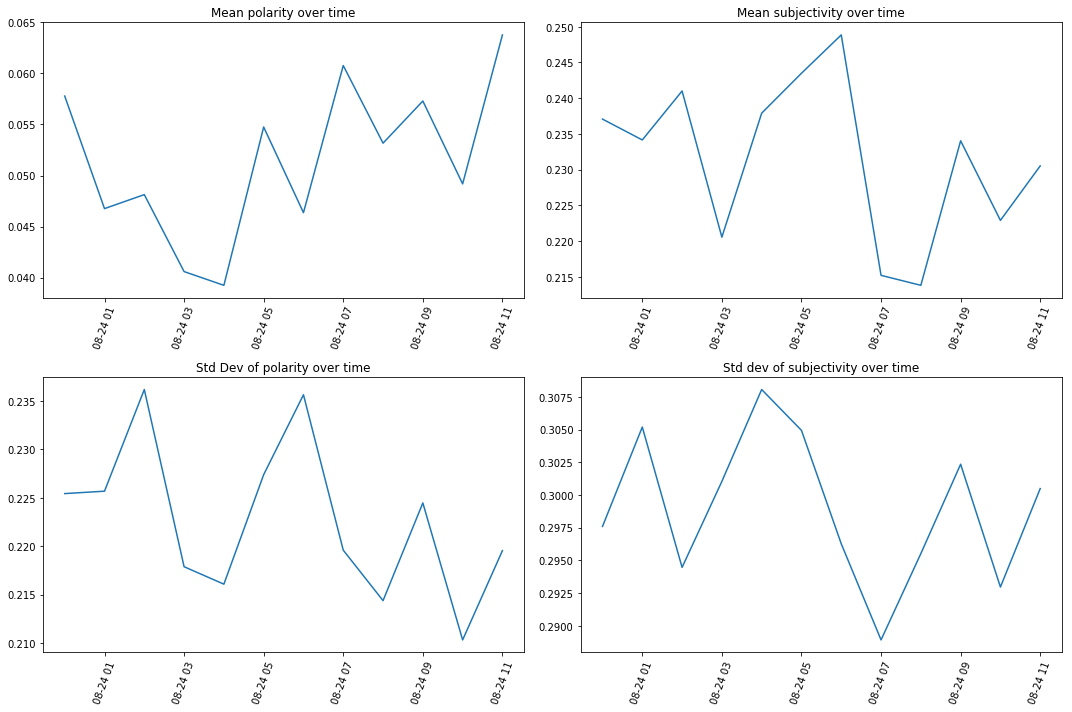

In [67]:
plot_data(news_feed_english_df , 'dt_hour')

## Visualisation grouped by dt_time

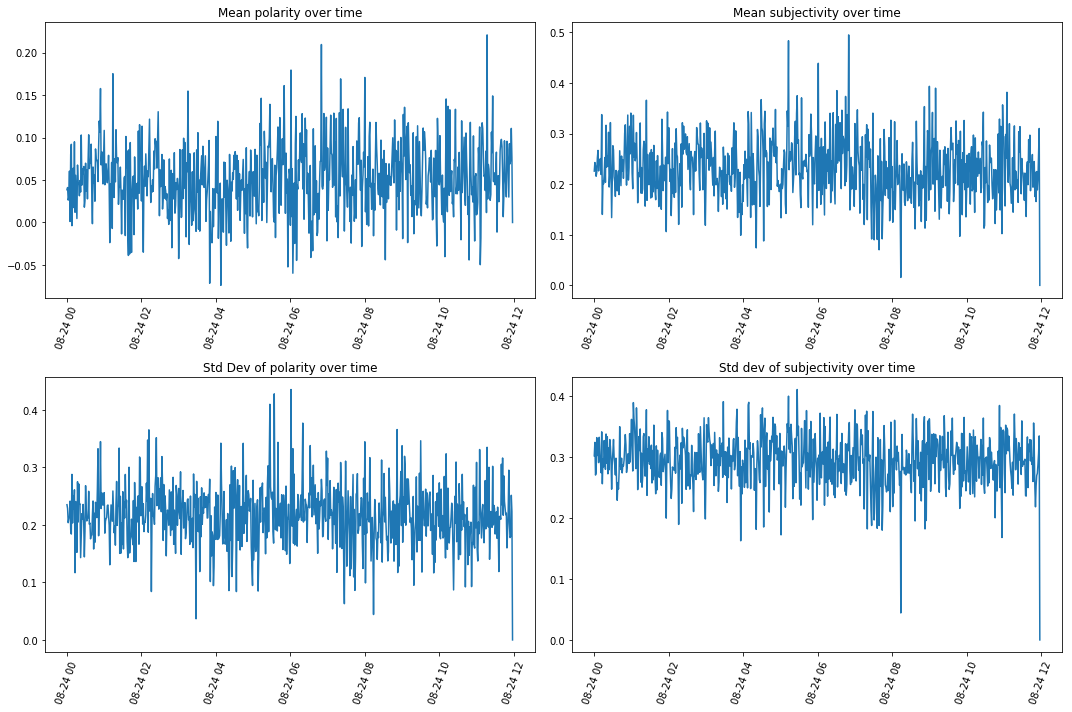

In [68]:
plot_data(news_feed_english_df , 'dt_time')